## 逻辑斯特回归示例

- [逻辑斯特回归](#逻辑斯特回归)
- [正则化后的逻辑斯特回归](#加正则化项的逻辑斯特回归)

In [2]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('dark')

In [3]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [15]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # 获得正负样本的下标(即哪些是正样本，哪些是负样本)
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

In [16]:
data =  loaddata('../../Demo_Ref/Linear-models/logistic_regression/data1.txt', ',')

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [17]:
X = np.c_[np.ones((data.shape[0],1)),data[:,0:2]]#将ndarray转为多维数组
y = np.c_[data[:,2]]


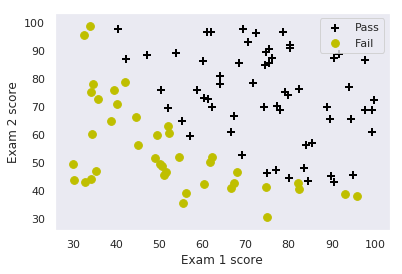

In [18]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Pass', 'Fail')

In [ ]:
#### 逻辑斯特回归假设
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [19]:
#定义sigmoid函数
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

其实scipy包里有一个函数可以完成一样的功能:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

#### 损失函数(交叉伤损失函数)
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### 向量化的损失函数(矩阵形式)
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$